In [36]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
import sys
from os import listdir
from os.path import isfile, join, exists
from scipy.spatial.distance import pdist, squareform
import scipy.io as sio
import scipy.stats as stats
from tqdm import tqdm
import time
import pymatreader
from IPython.core.debugger import set_trace
import copy
import h5py

import matplotlib.pyplot as plt

In [37]:
homedir = '/media/tarrlab/scenedata2/BOLD5000_GLMs/git/'
metric = 'reliability'
datasets = ['NSD','B5K']
versions = ['TYPEA_ASSUMEHRF', 'TYPEB_FITHRF', 'TYPED_FITHRF_GLMDENOISE_RR']

opts = dict()

opts['NSD'] = dict()
opts['B5K'] = dict()

opts['NSD']['subjs'] = ['subj01','subj02','subj03','subj04']
opts['B5K']['subjs'] = ['CSI1','CSI2','CSI3']

opts['NSD']['dir'] = '/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD'
opts['B5K']['dir'] = '/media/tarrlab/scenedata/BOLD5000_GLMsingle/betas/08_24_20_five-sess'

colors = ['dodgerblue','orange','tomato','black']

ft = 16


In [38]:
# load reliability data into struct

X = dict()

# iterate through datasets
for ds in tqdm(datasets):
    
    metricdir = join(homedir,'betas',opts[ds]['dir'].split('/')[-1],'metrics_v2')
    
    X[ds] = dict()
    
    # iterate through subjects
    for subj in opts[ds]['subjs']:
        
        X[ds][subj] = dict()

        subj_version_list = []
        
        # iterate through versions
        for version in versions:
            
            fn = join(metricdir, subj + '_' + version + '_' + metric + '.mat')
            assert(exists(fn))
            print(fn)
            
            # add each version's reliability data to struct
            X[ds][subj][version] = sio.loadmat(fn)[metric]
            
            subj_version_list.append(X[ds][subj][version])
        
        # also add that subject's mean of all versions
        X[ds][subj]['mean'] = np.mean(np.stack(subj_version_list,axis=3),axis=3)

  0%|          | 0/2 [00:00<?, ?it/s]

/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj01_TYPEA_ASSUMEHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj01_TYPEB_FITHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj01_TYPED_FITHRF_GLMDENOISE_RR_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj02_TYPEA_ASSUMEHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj02_TYPEB_FITHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj02_TYPED_FITHRF_GLMDENOISE_RR_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj03_TYPEA_ASSUMEHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj03_TYPEB_FITHRF_reliability.mat
/media/tarr

100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj04_TYPEA_ASSUMEHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj04_TYPEB_FITHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/09_08_20_one-sess_NSD/metrics_v2/subj04_TYPED_FITHRF_GLMDENOISE_RR_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/08_24_20_five-sess/metrics_v2/CSI1_TYPEA_ASSUMEHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/08_24_20_five-sess/metrics_v2/CSI1_TYPEB_FITHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/08_24_20_five-sess/metrics_v2/CSI1_TYPED_FITHRF_GLMDENOISE_RR_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/08_24_20_five-sess/metrics_v2/CSI2_TYPEA_ASSUMEHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_GLMs/git/betas/08_24_20_five-sess/metrics_v2/CSI2_TYPEB_FITHRF_reliability.mat
/media/tarrlab/scenedata2/BOLD5000_G

In [48]:
# temporal autocorrelation analysis 

opts['NSD']['nses'] = 10
opts['B5K']['nses'] = 15

rels = [0,0.3]

for ds in datasets:
    
    if ds == 'B5K':
        ds_ = 'BOLD5000'
    else:
        ds_ = 'NSD'
    
    for subj in tqdm(opts[ds]['subjs']):
        
        print(ds,subj)
        
        # get version-averaged reliability volume to use for ranking voxels
        reliability_vol = X[ds][subj]['mean']
         
        for version in versions:
            
            # iterate through versions, sessions
            for ses in range(1,opts[ds]['nses'] + 1):
                            
                if ses < 10:
                    sesstr = '0' + str(ses)
                else:
                    sesstr = str(ses)
                
                
                #print('checking to see if betas need to be loaded')
                
                # check to see if betas need to be loaded
                loadbetas = False
                for rel in rels:
                    savedir = join(homedir, 'sessionRDMs', ds_, subj, version)
                    
                    if not exists(savedir):
                        os.makedirs(savedir,exist_ok=True)
                    
                    # if at least one file needs to be computed, load the session betas
                    savefn = join(savedir, 'RDM_session' + sesstr + '_relthresh_' + str(rel).replace('.','_') + '.npy')
                    if not exists(savefn):
                        loadbetas = True

                if loadbetas is True:
                    
                    #print('loading betas')
                    
                    if ds == 'B5K':
                        betafn = join(opts[ds]['dir'],subj,version,'betas_session' + sesstr + '.nii.gz')
                        assert(exists(betafn))

                        betas = nib.load(betafn).get_data()[:,:,:,:333]

                    elif ds == 'NSD':
                        if 'ASSUME' in version:
                            betafn = join(opts[ds]['dir'] + '_assume',subj,'session' + sesstr,'TYPEB_FITHRF.mat')
                        else: 
                            betafn = join(opts[ds]['dir'],subj,'session' + sesstr,version + '.mat')

                        betas = pymatreader.read_mat(betafn)['modelmd']

                    # zscore the activity pattern of each voxel within session
                    betas = stats.zscore(betas,axis=3)

                    # threshold at each reliability value
                    for rel in rels:
                        
                        #print(ds,subj,version,sesstr,rel)

                        savefn = join(savedir, 'RDM_session' + sesstr + '_relthresh_' + str(rel).replace('.','_') + '.npy')
                        
                        if not exists(savefn):
                            
                            # compute RDM
                            mask = np.logical_and(np.logical_not(np.isnan(betas[:,:,:,0])), (reliability_vol > rel))
                            betas_2D = betas[mask].T

                            assert(np.sum(np.isnan(betas_2D)) == 0)

                            RDM = squareform(pdist(betas_2D,'correlation'))
                            #print('saving RDM\n')
                            np.save(savefn, RDM)

                #else:
                    #print('all files already computed. done.\n')
                    
                    
                
                

100%|██████████| 3/3 [00:00<00:00, 616.02it/s]

NSD subj01
NSD subj02
NSD subj03
NSD subj04
B5K CSI1
B5K CSI2
B5K CSI3


In [ ]:
def compute_autocorr_fn(rdm, maxlag = 50):
    assert(rdm.shape[0] == rdm.shape[1])
    assert(np.sum(np.isnan(rdm)) == 0)
    
    summary = []
    for lag in range(1,maxlag+1):
        corrs = []
        for i in range(rdm.shape[0]-lag):
            corrs.append(rdm[i+lag,i])
        summary.append(np.mean(corrs))
    return summary
            

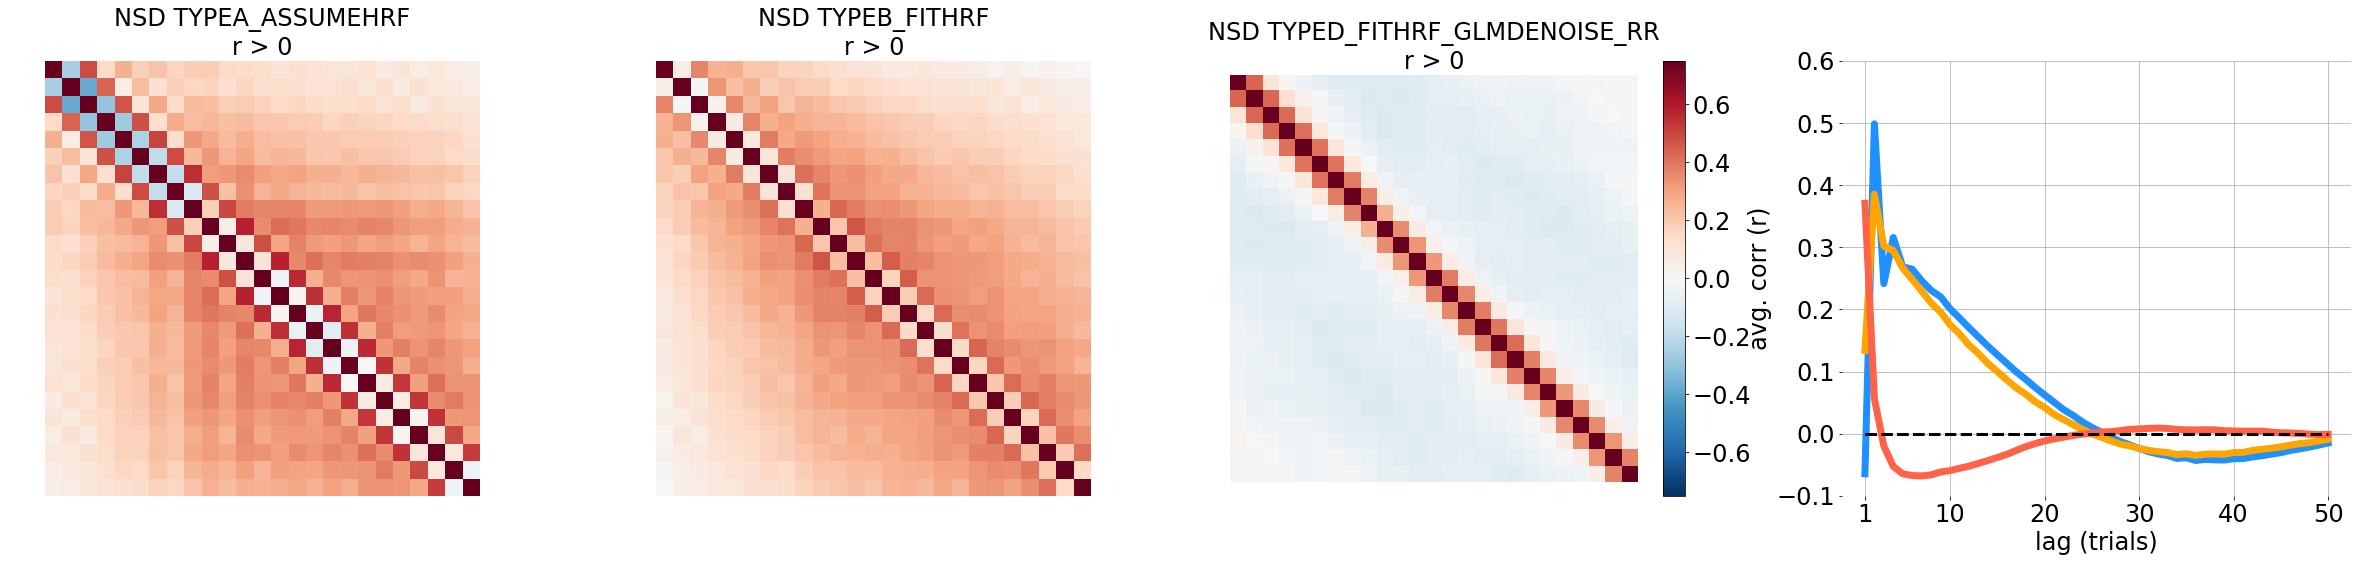

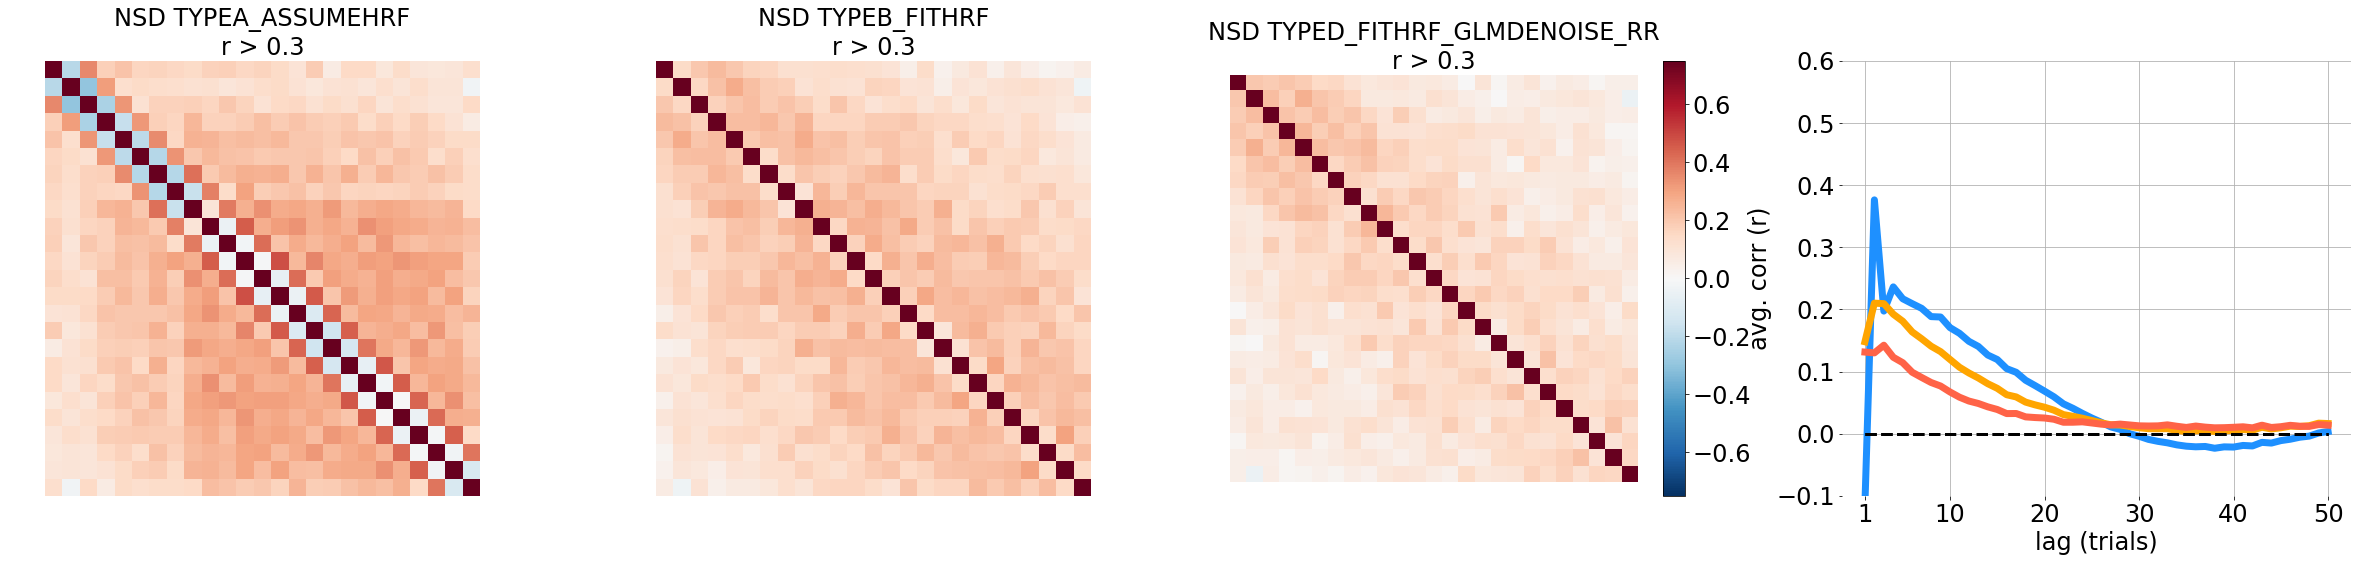

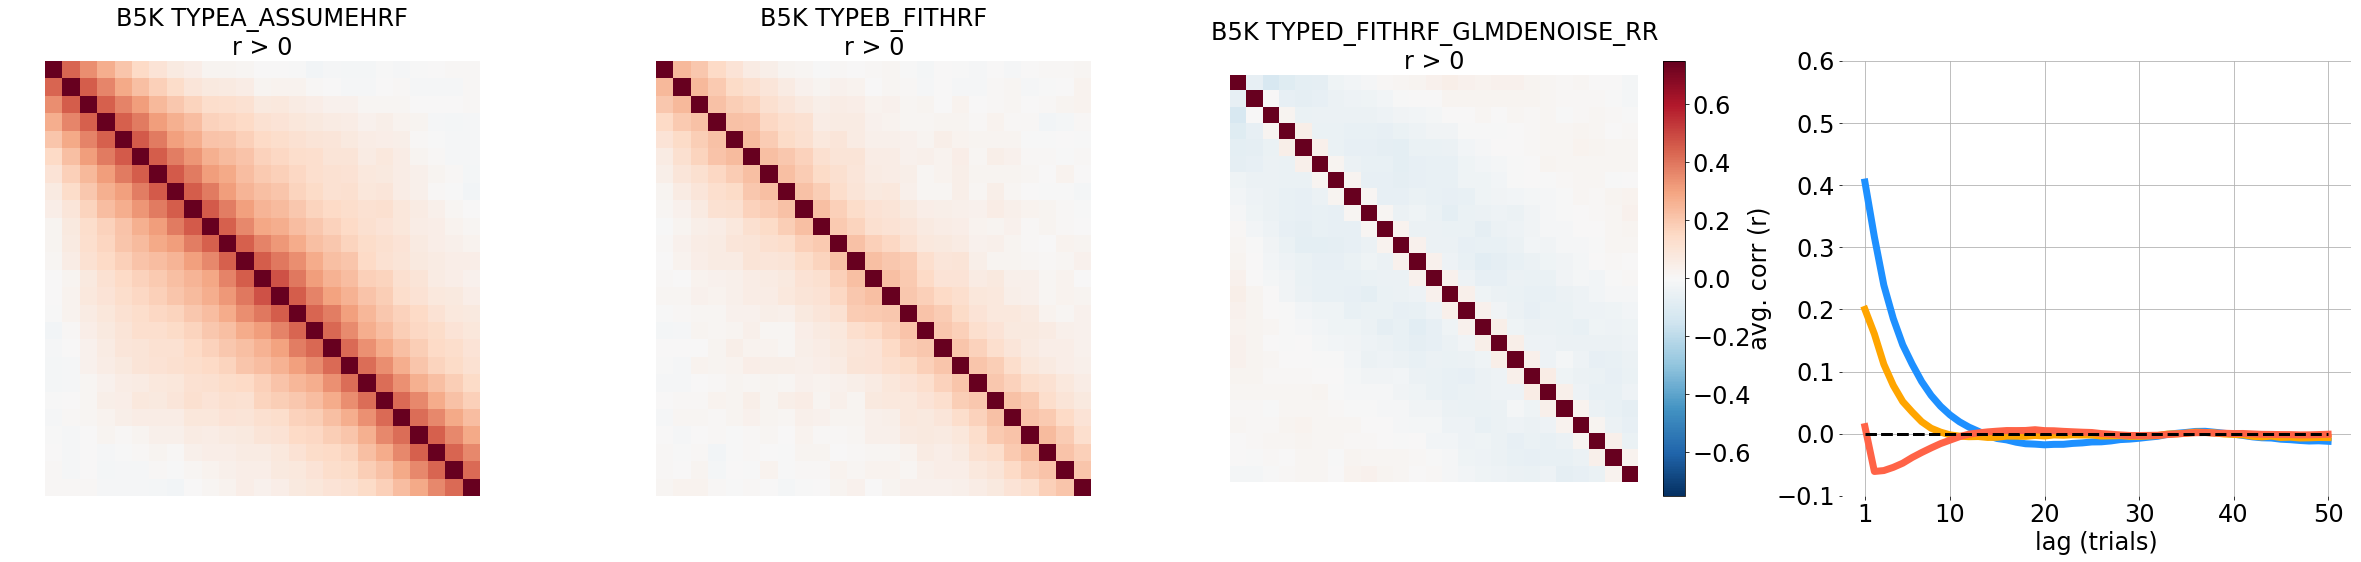

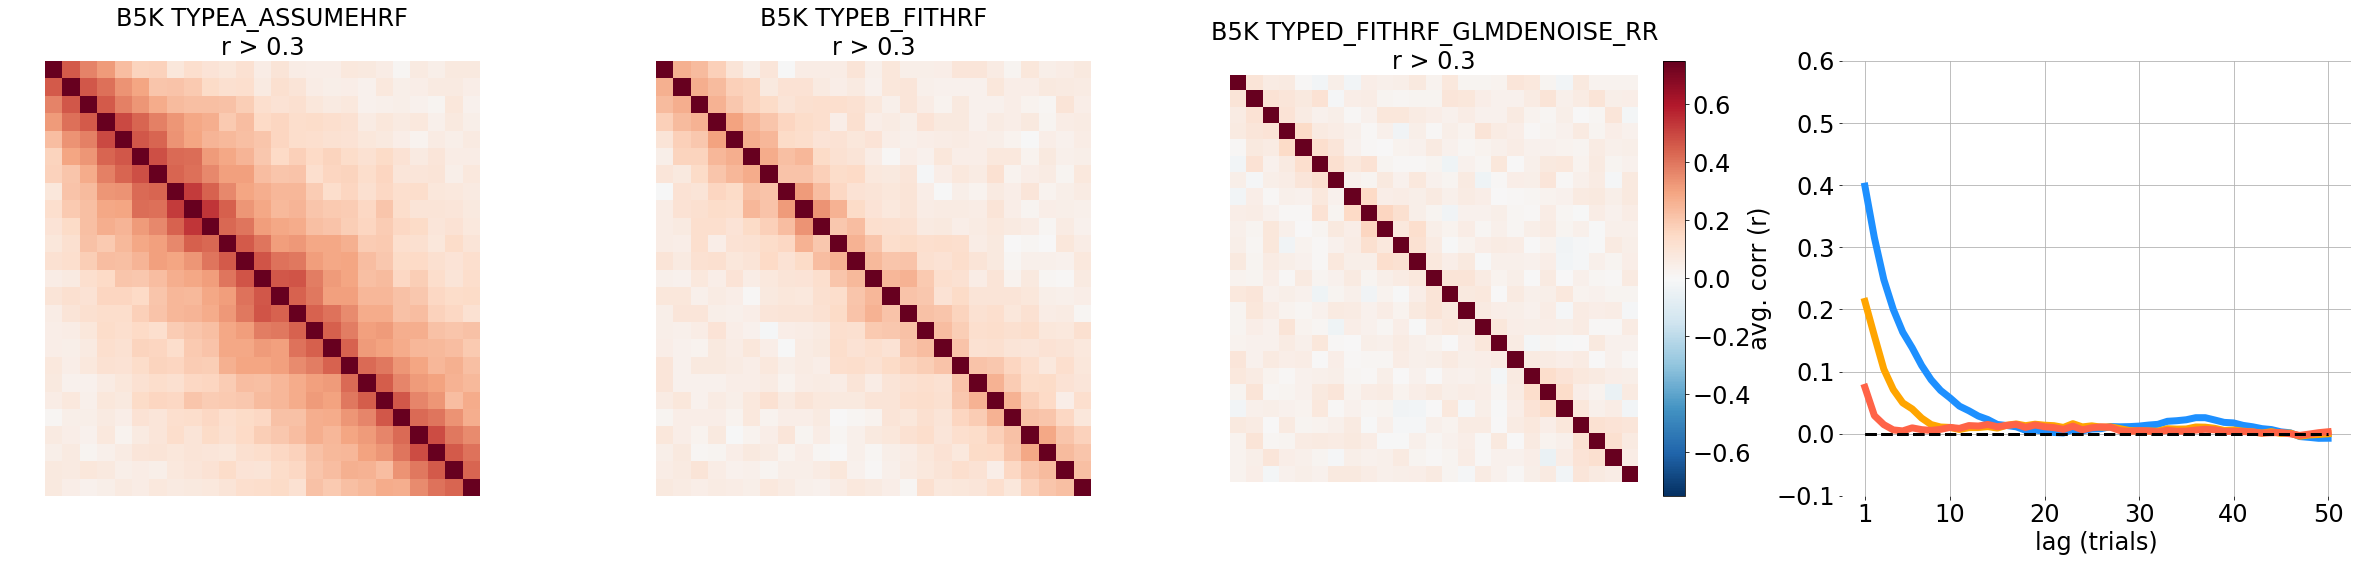

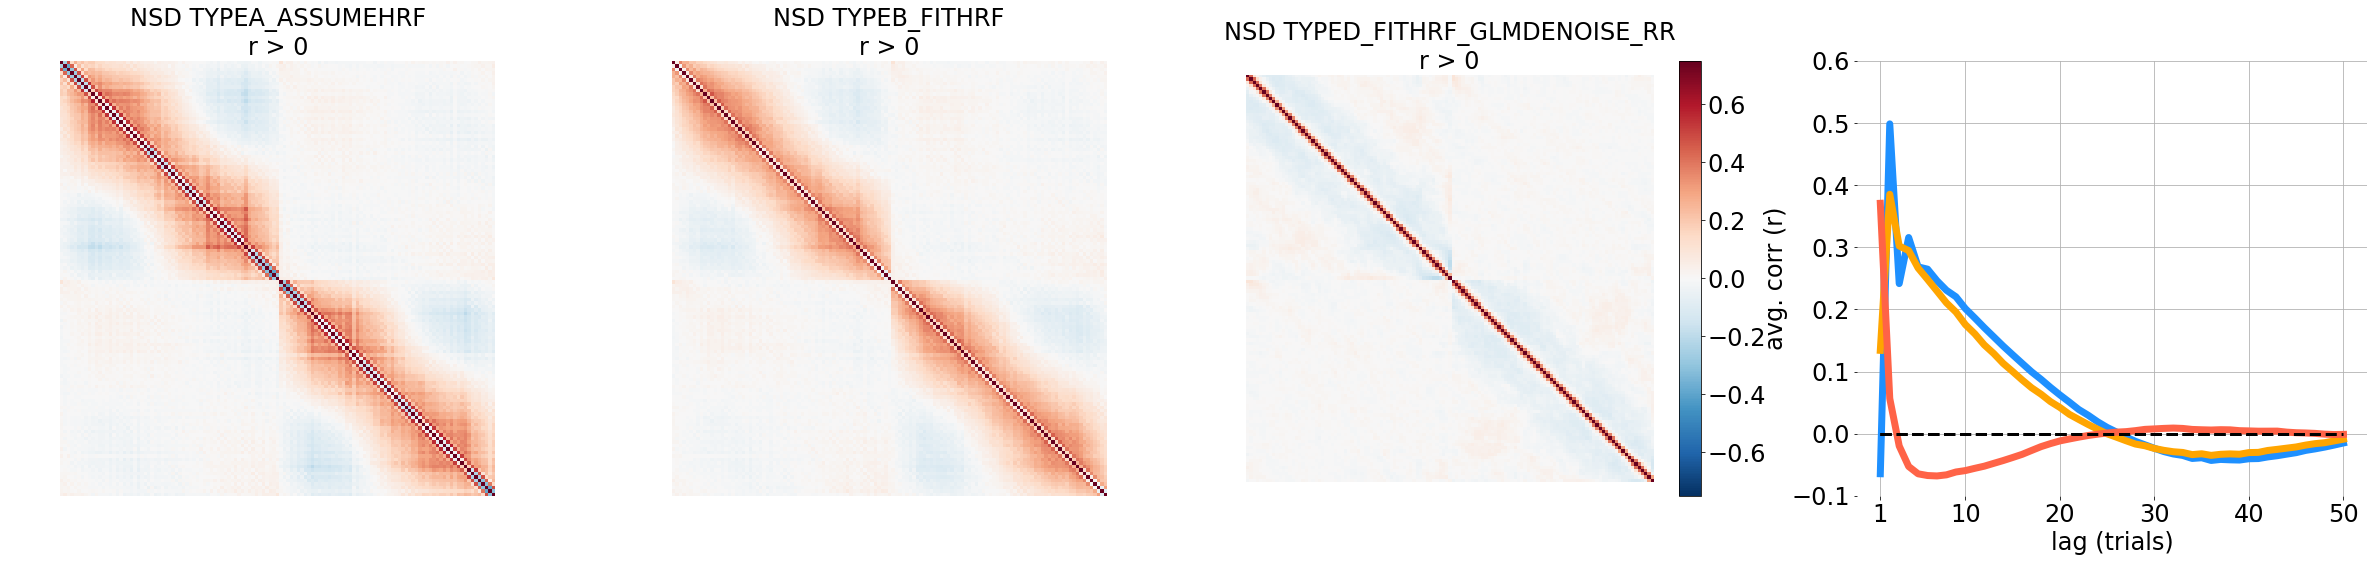

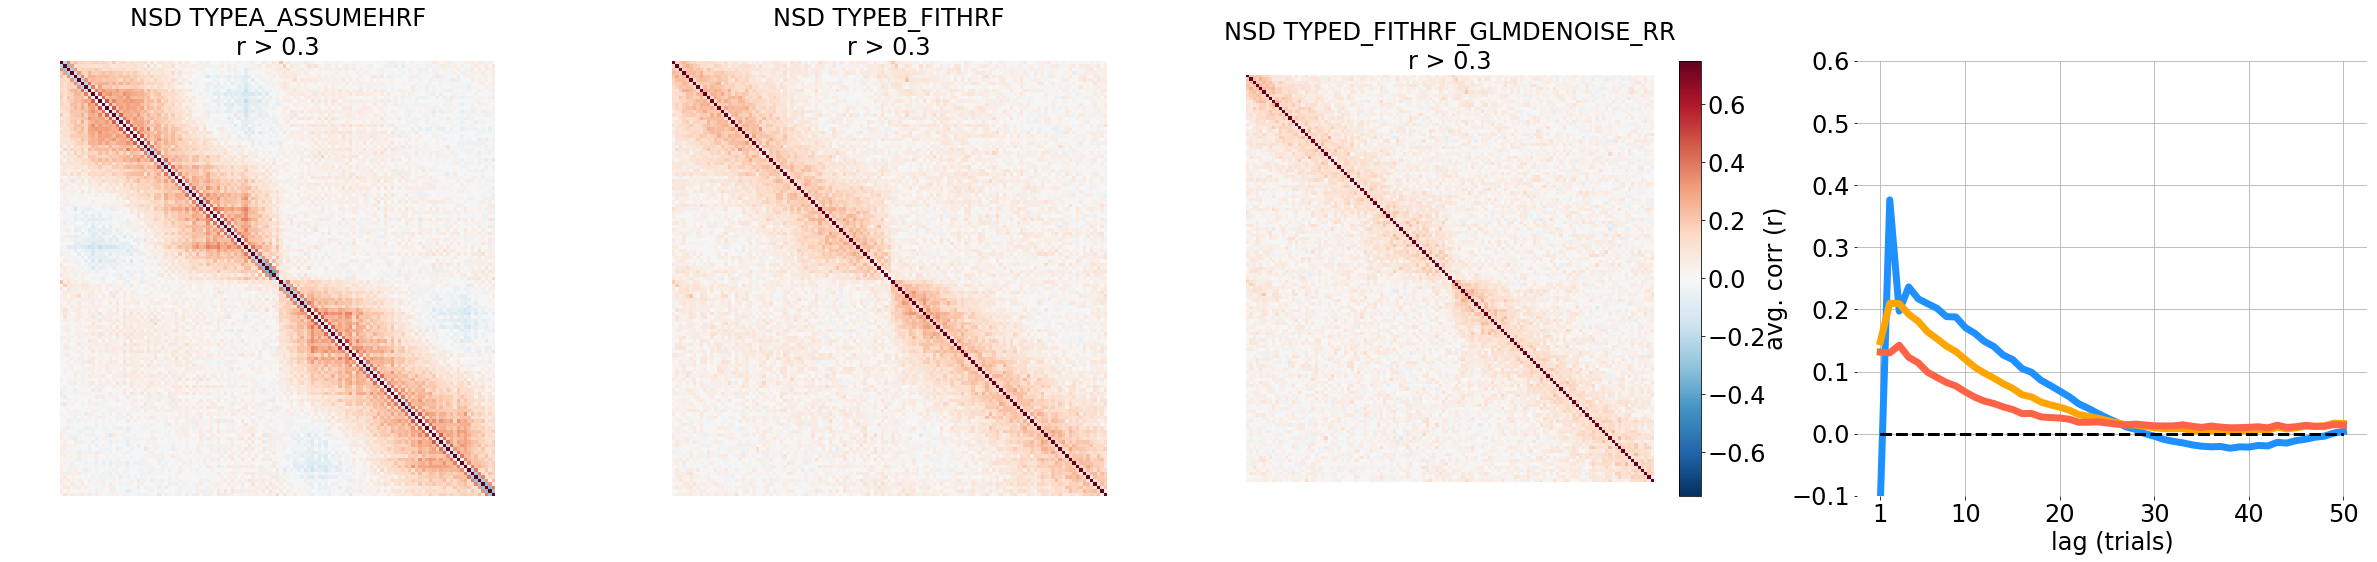

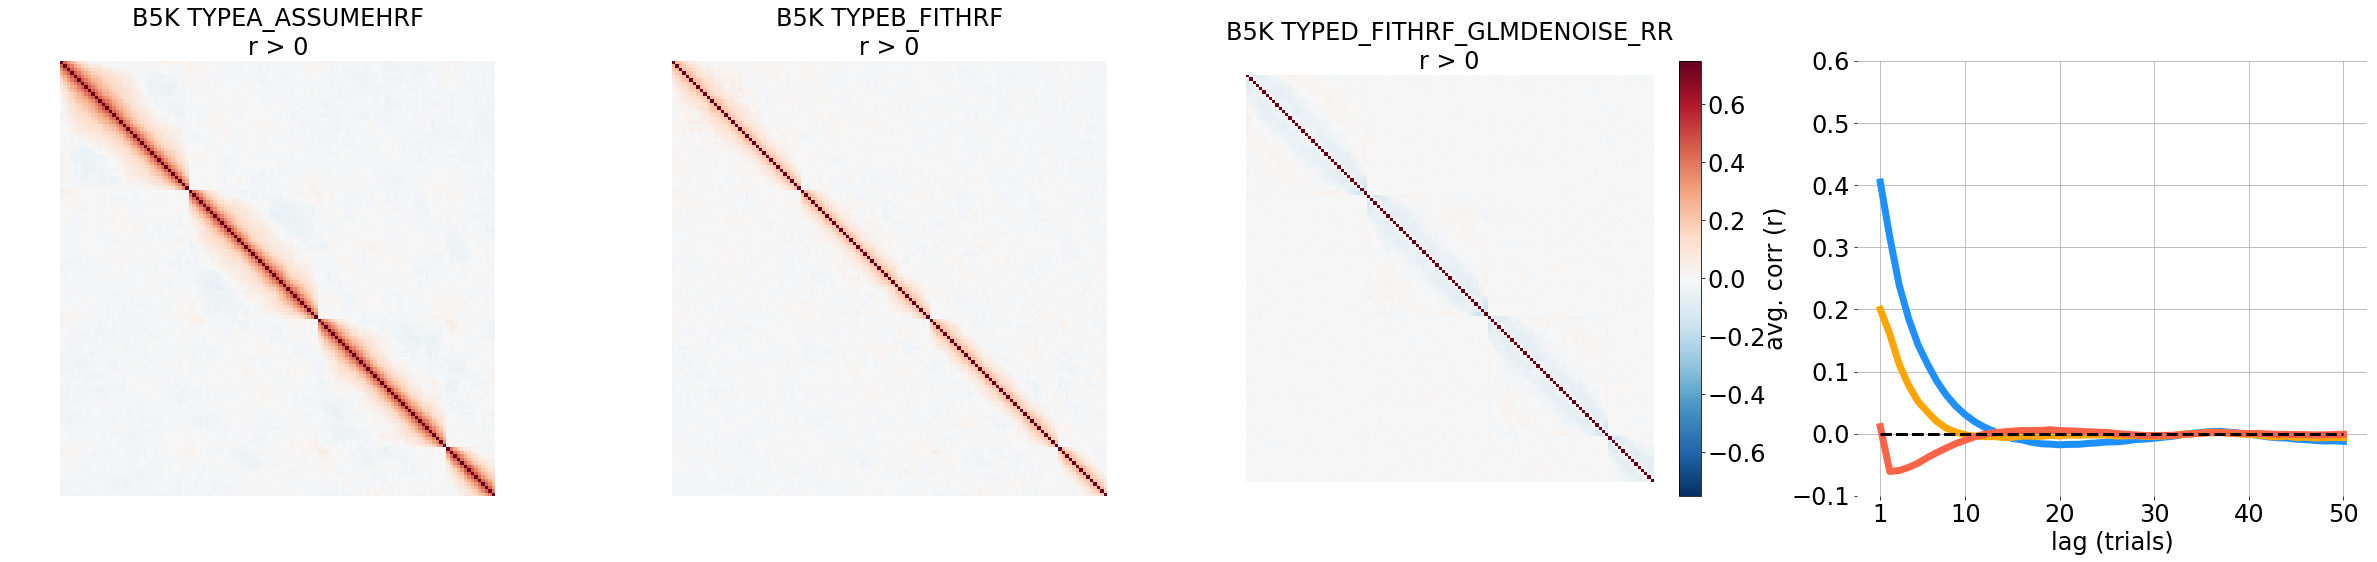

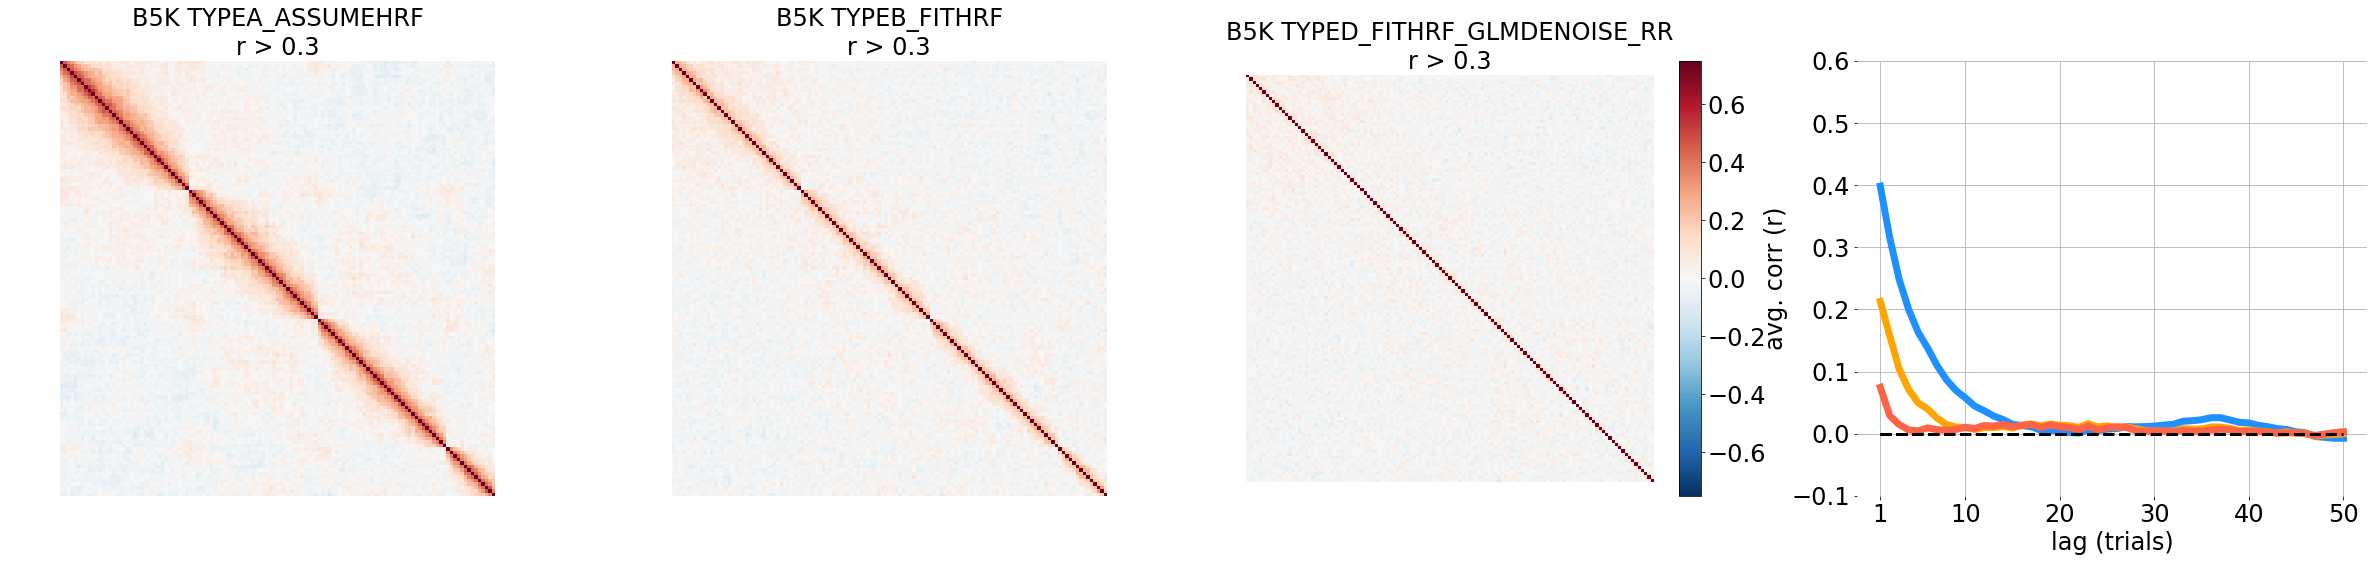

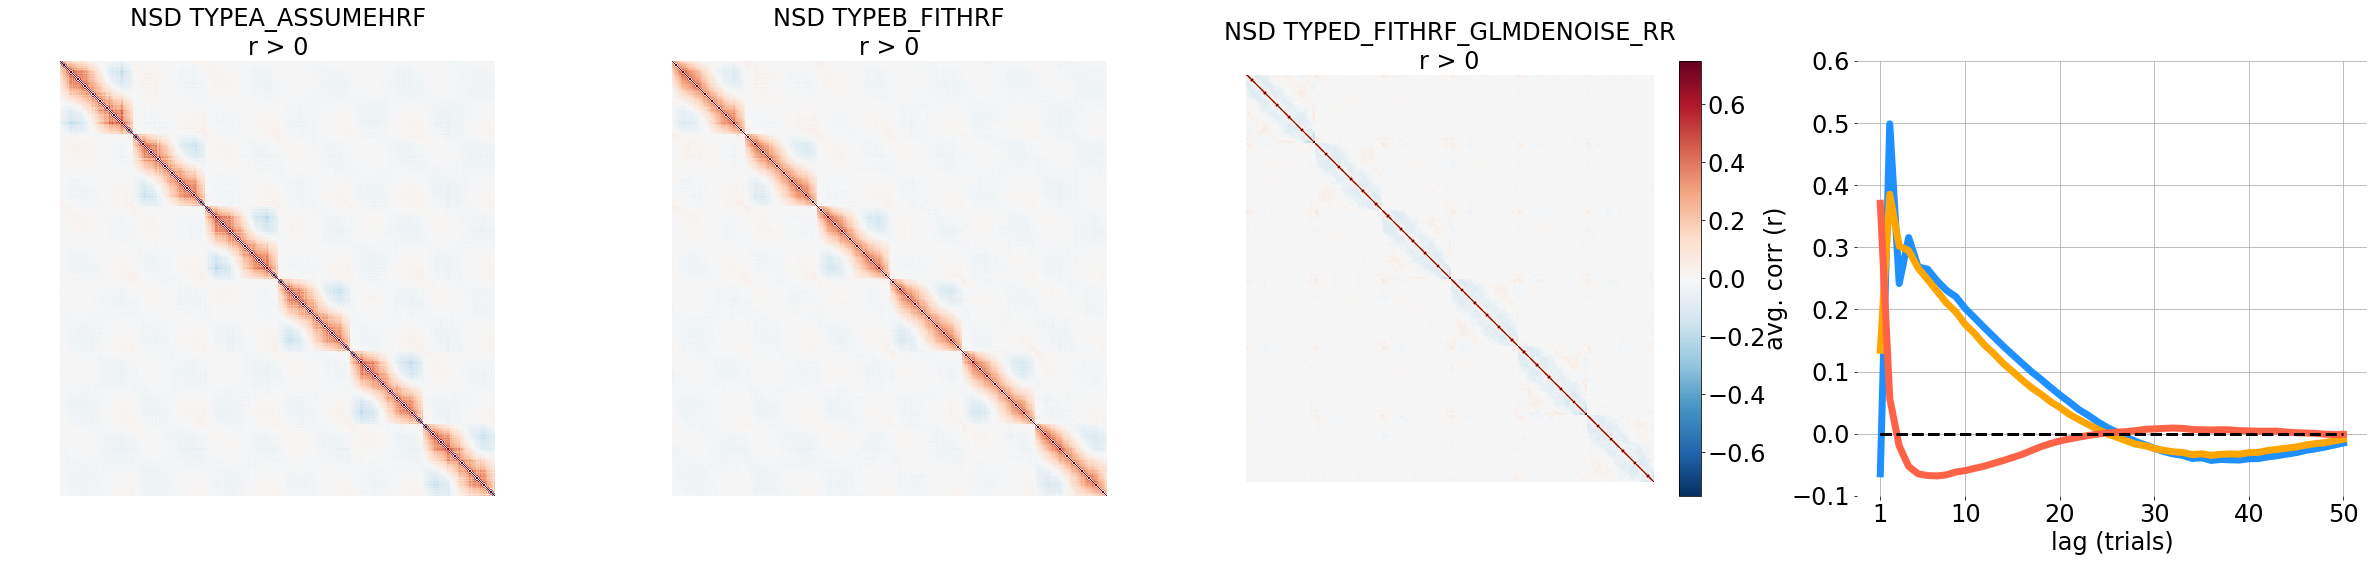

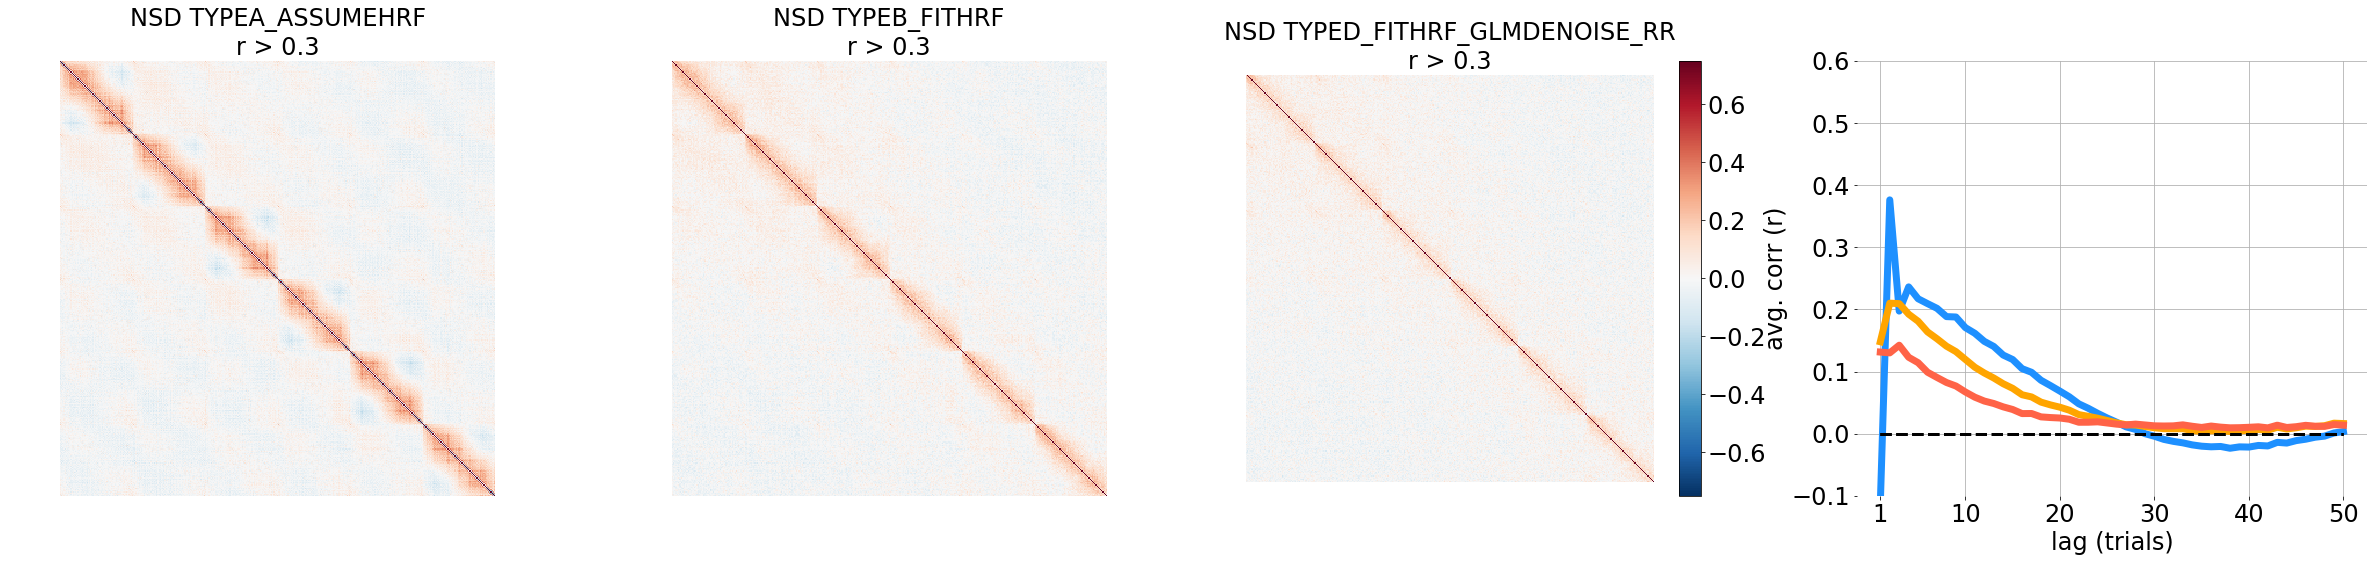

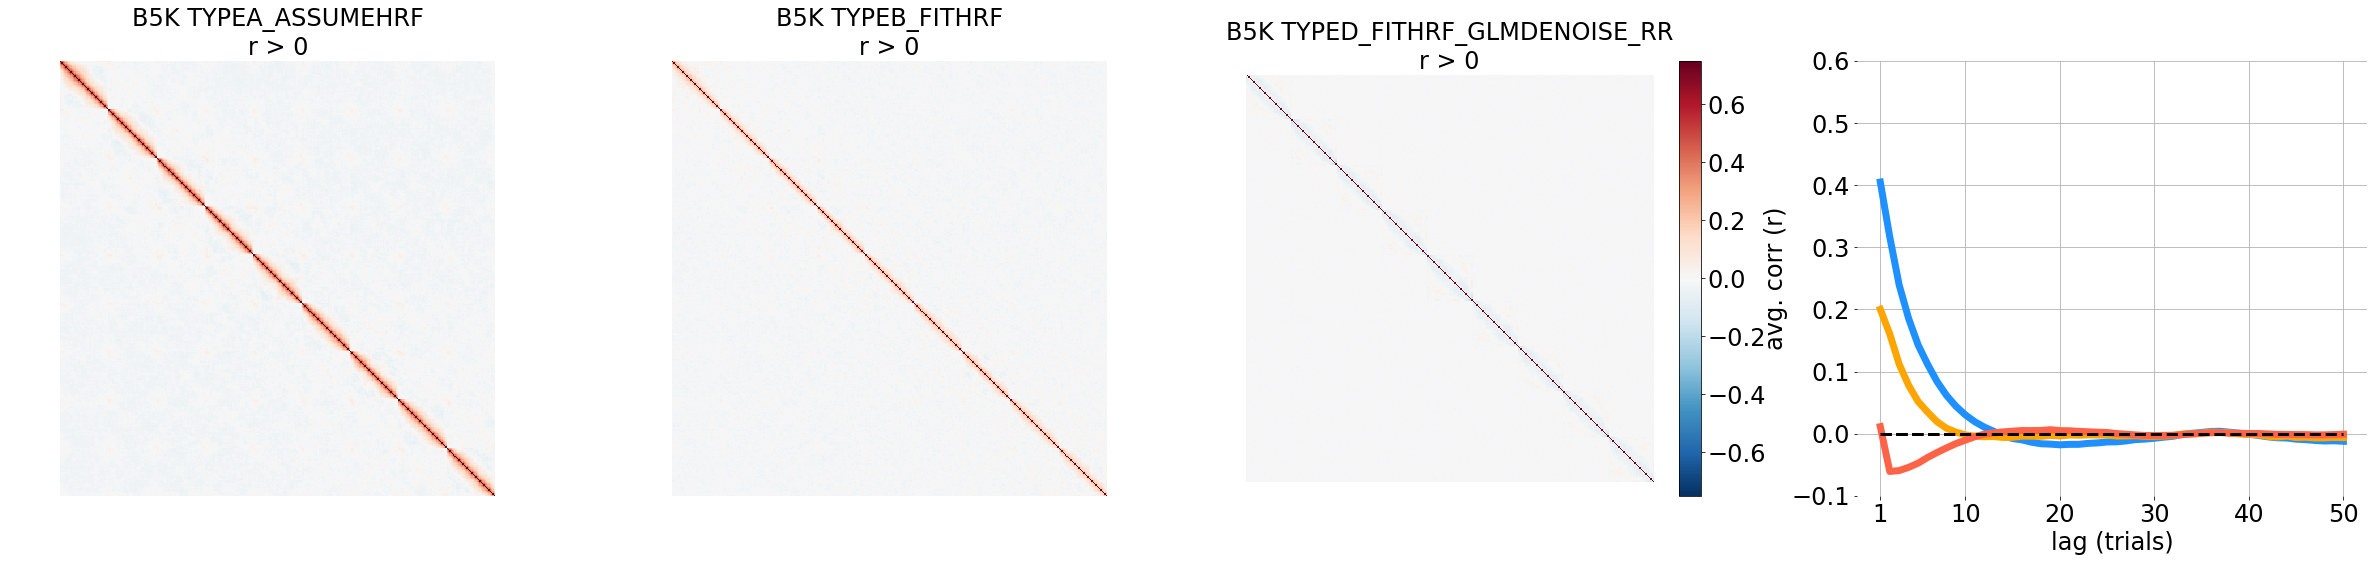

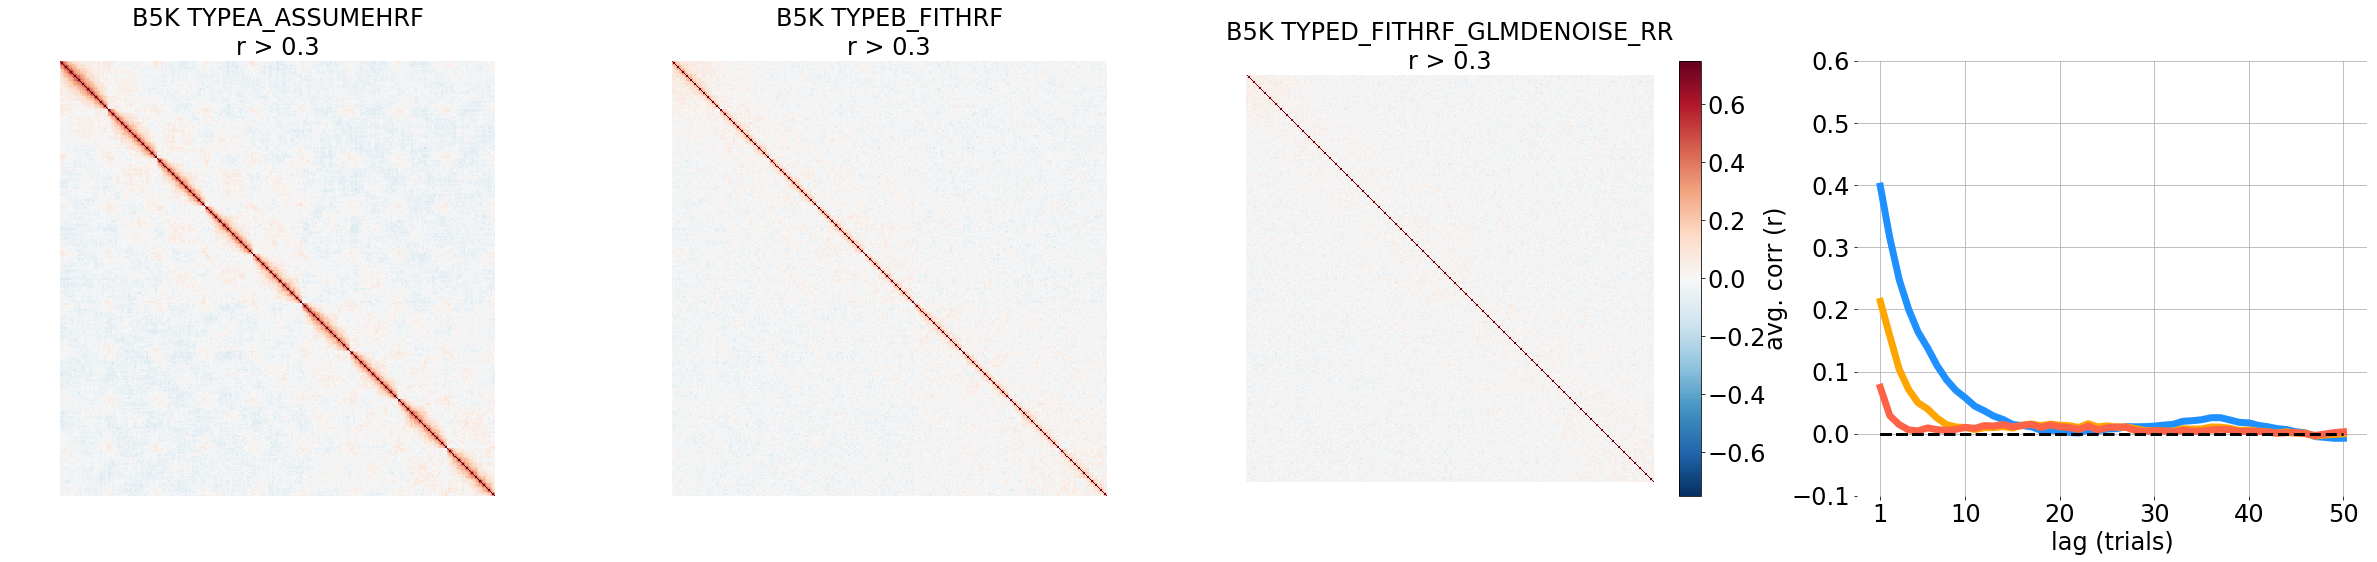

In [97]:
# temporal autocorrelation analysis 

fts = 24
colors = ['dodgerblue','orange','tomato']

rels = [0,0.3]
ns = [25, 125, 375]

for n in ns:

    RDMs = dict()

    for ds in datasets:

        RDMs[ds] = dict()

        for rel in rels:

            RDMs[ds][str(rel)] = dict()

            plt.figure(figsize=(42,8))
            c = 1

            for version in versions:
                plt.subplot(1,len(versions)+1,c)

                RDMs[ds][str(rel)][version] = []

                if ds == 'B5K':
                    ds_ = 'BOLD5000'
                else:
                    ds_ = 'NSD'

                for subj in opts[ds]['subjs']:

                    # iterate through versions, sessions
                    for ses in range(1,opts[ds]['nses'] + 1):

                        if ses < 10:
                            sesstr = '0' + str(ses)
                        else:
                            sesstr = str(ses)

                        savedir = join(homedir, 'sessionRDMs', ds_, subj, version)

                        # if at least one file needs to be computed, load the session betas
                        loadfn = join(savedir, 'RDM_session' + sesstr + '_relthresh_' + str(rel).replace('.','_') + '.npy')

                        RDM = np.load(loadfn)
                        RDMs[ds][str(rel)][version].append(RDM)

                this_meanRDM = 1 - np.mean(np.stack(RDMs[ds][str(rel)][version],axis=2),axis=2)


                plt.imshow(this_meanRDM[:n,:n],clim=(-0.75,0.75),cmap='RdBu_r')
                plt.xticks(fontsize=fts)
                plt.yticks(fontsize=fts)
                plt.axis('off')
                plt.title(ds + ' ' + version + '\n' + 'r > ' + str(rel),fontsize=fts)
                if c == 3:
                    cbar=plt.colorbar()
                    cbar.ax.tick_params(labelsize=fts) 
                
                plt.subplot(1,len(versions)+1,4)
                autocorr = compute_autocorr_fn(this_meanRDM,50)
                plt.plot(autocorr,linewidth=7,color=colors[c-1])
                plt.plot(np.arange(len(autocorr)),np.zeros((len(autocorr),)),'k--',linewidth=3)
                plt.ylim([-0.1,0.6])
                plt.grid('on')
                plt.xticks(np.array([1,10,20,30,40,50])-1, np.array([1,10,20,30,40,50]),fontsize=fts)
                plt.yticks(fontsize=fts)
                plt.xlabel('lag (trials)',fontsize=fts)
                plt.ylabel('avg. corr (r)',fontsize=fts)
                # get rid of the frame
                for spine in plt.gca().spines.values():
                    spine.set_visible(False)

                c+=1
